
Evaluación de Modelos con las 5 Características más Importantes:

Logistic Regression - Ajuste de Hiperparámetros
Mejores parámetros: {'solver': 'liblinear', 'max_iter': 500, 'C': 1}
Logistic Regression - Accuracy: 0.9938
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12890
           1       0.00      0.00      0.00        77

    accuracy                           0.99     12967
   macro avg       0.50      0.50      0.50     12967
weighted avg       0.99      0.99      0.99     12967



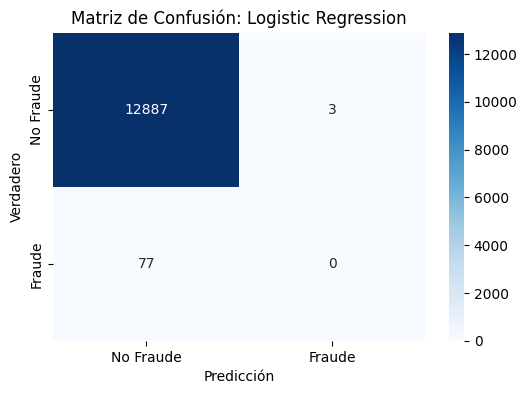


Random Forest - Ajuste de Hiperparámetros
Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}
Random Forest - Accuracy: 0.9948
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12890
           1       0.69      0.23      0.35        77

    accuracy                           0.99     12967
   macro avg       0.84      0.62      0.67     12967
weighted avg       0.99      0.99      0.99     12967



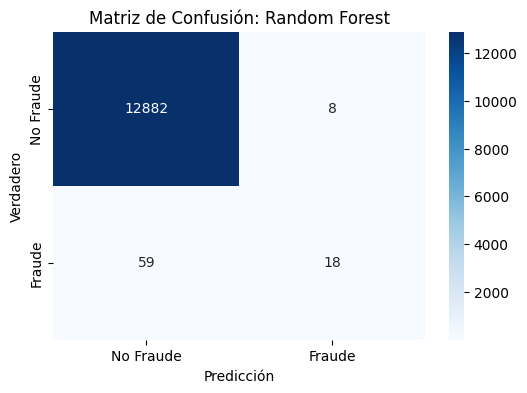


Linear Regression - Ajuste de Hiperparámetros
Linear Regression no requiere ajuste de hiperparámetros.
Linear Regression - Accuracy: 0.9941
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12890
           1       0.00      0.00      0.00        77

    accuracy                           0.99     12967
   macro avg       0.50      0.50      0.50     12967
weighted avg       0.99      0.99      0.99     12967



c:\Users\magic\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\magic\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\magic\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

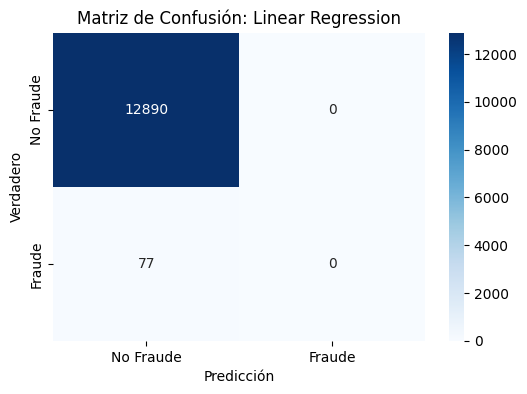

C:\Users\magic\AppData\Local\Temp\ipykernel_28480\3754235464.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Accuracy', data=results_df, palette='viridis')


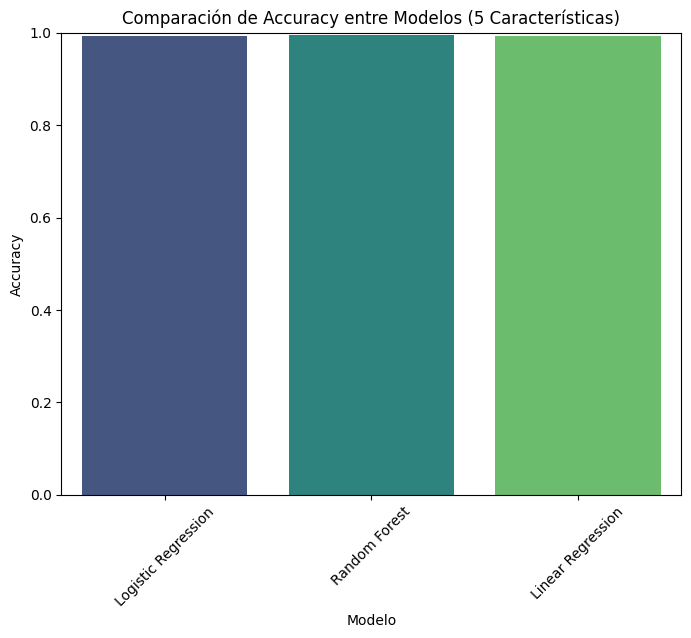

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Cargar los datos (reemplaza con tu archivo de datos)
data = pd.read_csv("credit_card_transactions.csv")

# Tomar el 5% de los datos desde el inicio
data = data.sample(frac=0.05, random_state=42)

# Definir X (características) y y (target)
y = data['is_fraud']
X = data.drop(columns=['is_fraud', 'trans_date_trans_time', 'cc_num', 'merchant', 'street', 'city', 
                       'state', 'zip', 'lat', 'long', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'category'])

# Manejar variables categóricas
X = pd.get_dummies(X, drop_first=True)

# Imputar los valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Seleccionar las 5 características más importantes usando Random Forest
rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X_train_scaled, y_train)

# Obtener las 5 características más importantes
importances = rf_temp.feature_importances_
indices = np.argsort(importances)[::-1][:5]  # Índices de las 5 características más importantes

# Reducir X_train y X_test a estas 5 características
X_train_selected = X_train_scaled[:, indices]
X_test_selected = X_test_scaled[:, indices]

# Definir los modelos y sus parámetros
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Linear Regression': LinearRegression()  # Agregar Linear Regression
}

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 500, 1000]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced'],
    }
}

# Ajustar y evaluar los modelos con las 5 características seleccionadas
tuned_results = {}

print("\nEvaluación de Modelos con las 5 Características más Importantes:")
results = []

for name, model in models.items():
    print(f"\n{name} - Ajuste de Hiperparámetros")
    
    # Si el modelo tiene un grid de parámetros, realizar el ajuste
    if name in param_grids:
        param_grid = param_grids[name]
        search = RandomizedSearchCV(
            model,
            param_distributions=param_grid,
            n_iter=5,
            scoring='accuracy',
            cv=3,
            random_state=42,
            n_jobs=1
        )
        search.fit(X_train_selected, y_train)
        tuned_results[name] = search.best_params_
        model.set_params(**search.best_params_)
        print(f"Mejores parámetros: {search.best_params_}")
    else:
        print(f"{name} no requiere ajuste de hiperparámetros.")

    # Entrenar el modelo
    model.fit(X_train_selected, y_train)

    # Realizar predicciones
    if name == 'Linear Regression':
        # Predicciones continuas para la regresión lineal
        y_pred_continuous = model.predict(X_test_selected)
        # Convertir las predicciones en clases usando un umbral de 0.5
        y_pred = (y_pred_continuous >= 0.5).astype(int)
    else:
        y_pred = model.predict(X_test_selected)

    # Evaluación
    acc = accuracy_score(y_test, y_pred)
    results.append({'Modelo': name, 'Accuracy': acc})
    print(f"{name} - Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
    plt.title(f'Matriz de Confusión: {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.show()

# Comparación de modelos
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
sns.barplot(x='Modelo', y='Accuracy', data=results_df, palette='viridis')
plt.title('Comparación de Accuracy entre Modelos (5 Características)')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()


In [ ]:
import joblib

# Guardar cada modelo
joblib.dump(models['Logistic Regression'], 'logistic_regression_model.pkl')
joblib.dump(models['Random Forest'], 'random_forest_model.pkl')
joblib.dump(models['Linear Regression'], 'linear_regression_model.pkl')

# Guardar el escalador y los índices de las características seleccionadas
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(indices, 'feature_indices.pkl')


['feature_indices.pkl']

In [ ]:
# Reducir los datos a las 5 características seleccionadas
X_train_selected = X_train_scaled[:, indices]
X_test_selected = X_test_scaled[:, indices]

# Entrenar un nuevo StandardScaler solo para las 5 características seleccionadas
scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

# Reentrenar los modelos con las características escaladas reducidas
rf_model = models['Random Forest'].fit(X_train_selected_scaled, y_train)
logistic_model = models['Logistic Regression'].fit(X_train_selected_scaled, y_train)
linear_model = models['Linear Regression'].fit(X_train_selected_scaled, y_train)

# Guardar el nuevo escalador y los modelos
import joblib
joblib.dump(scaler_selected, 'scaler_selected.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(logistic_model, 'logistic_regression_model.pkl')
joblib.dump(linear_model, 'linear_regression_model.pkl')


['linear_regression_model.pkl']